# Coastline Recession in Bangladesh: A Temporal Analysis
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/planetlabs/notebooks/blob/scipy-2022/jupyter-notebooks/scipy-2022-workshop/coastline_analysis.ipynb)

In this notebook tutorial, we will be analyzing a pretty severe example of coastal erosion. To do so we will:
- Extract data from multi-band imagery
- Compute the normalized difference water index (NDWI)
- Identify which pixels are associated to water and land with the NDWI
- Analyze coastal erosion within the area of interest (AOI), using classical image processing and computer vision techniques

We have provided you with data for your AOI, which has already been mosaiced, processed, and downloaded.

This AOI and analysis has been inspired by a recent paper: Crawford, T.W. et al., Coastal Erosion and Human Perceptions of Revetment Protection in the Lower Meghna Estuary of Bangladesh. Remote Sens. 2020, 12, 3108. https://doi.org/10.3390/rs12183108

**For this tutorial, you will need to:**
- Download all of the data needed for this analysis. If you're running this in Colab, then the data will already be downloaded. Otherwise, please download these data in advance of the tutorial, as this may take some time: 
https://github.com/planetlabs/notebooks/blob/scipy-2022/jupyter-notebooks/scipy-2022-workshop/0_download_data.ipynb
- Install and import the packages below

In [304]:
!wget -q -O tmp.zip https://hello.planet.com/data/s/Y2wFKNFNTwHxot8/download/scipy2022_workshop_data.zip && unzip tmp.zip && rm tmp.zip

In [305]:
!pip install rasterio

In [1]:
from glob import glob

import rasterio
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

%matplotlib inline

## Retrieve data
Within our data folder, labelled `scipy2022_workshop_data`, we have both analytic images and visual images. While these images reflect the same AOI, they are used for different purposes. The visual images are colour-corrected and intended to be viewed and analyzed by the human eye, while the analytical images are unorthorectified, radiometrically-calibrated, and are stored as 16-bit scaled radiance, which are intended to be used for scientific purposes.

Let's retrieve both the multi-band and visual-band images across our entire time of interest (2017 - 2022), then sort the data to be chronological.

We have chosen to image the AOI once each spring. The AOI is located in Southen Bangladesh, where the ocean (Bay of Bengal) meets the a major inlet, the Meghna River.

<img src="assets/AOI.png" width=600 height=600 />

In [307]:
# change this directory as needed to reflect your local files
data_directory = "scipy2022_workshop_data"

analytic_filenames = glob(data_directory + "/*analytic/composite.tif")
visual_filenames = glob(data_directory + "/*visual/composite.tif")

analytic_filenames.sort()
visual_filenames.sort()

## Extract spectral bands
Create a function to extract spectral bands from a PanetScope 4-band imagery.
These spectral bands will be used later to compute the normalized difference water index (NDWI), which will be used
to find which pixels are associated to water and which are associated to land.

In [308]:
def extract_spectral_bands(image_filename):
    """
    Extracts green, red, and NIR band data from a PlanetScope 4-band image.

    Parameters:
    -----------
        image_filename : str
                     The input path to a PlanetScope 4-Band image.
    
    Returns:
    --------
        band_green : Array[int]
                     Green band image.
        band_nir :   Array[int]
                     NIR band image.
    """
    with rasterio.open(image_filename) as src:
        band_green = src.read(2)

    with rasterio.open(image_filename) as src:
        band_nir = src.read(4)

    return band_green, band_nir

## Compose scene using visual imagery
Create a function to compose a scene, given red, green, and blue bands from
visual band PanetScope 4-band imagery.

In [309]:
def compose_scene(image_filename):
    """
    Extracts red, green, and blue bands from a PlanetScope 4-band image and
    stacks them to compose a scene.

    Parameters:
    -----------
        image_filename : str
                     The input path to a PlanetScope 4-Band image.
    
    Returns:
    --------
        band_red :   Array[int]
                     Red band image.
        band_green : Array[int]
                     Green band image.
        band_blue :  Array[int]
                     Blue band image.
    """

    # Extract visual imagery
    with rasterio.open(image_filename) as src:
        band_red = src.read(1)
    with rasterio.open(image_filename) as src:
        band_green = src.read(2)
    with rasterio.open(image_filename) as src:
        band_blue = src.read(3)

    visual_image = np.dstack((band_red, band_green, band_blue))

    return visual_image

## Compute the Normalized Difference Water Index (NDWI)
This function will measure the
[normalized difference water index](https://en.wikipedia.org/wiki/Normalized_difference_water_index) (NDWI), 
defined as: `NDWI = (green - NIR) / (green + NIR)`.

In [310]:
def measure_ndwi(band_green, band_nir):
    """
    Measures the normalized difference water index (NDWI).

    Parameters:
    -----------
        band_green : Array[int]
               Normalized green band image.
        band_nir : Array[int]
               Normalized NIR band image.
    
    Returns:
    --------
        ndwi : Array[float]
               Normalized difference water index    
    """

    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')

    # Calculate NDWI
    ndwi = (band_green.astype(float) - band_nir.astype(float)) / (band_green +
                                                                  band_nir)

    return ndwi

## Find water and land pixels
NDWI values range from -1 to +1. Pixels which have a relatively high NDWI value (NDWI >= 0.3) are likely to be
associated with water, whereas pixels with values under this threshold 
(NDWI < 0.3) are unlikely to be associated with water.

In [311]:
def find_water_and_land(ndwi):
    """
    Given an NDWI image, associate an image's pixels with either water or land.

    Parameters:
    -----------
        ndwi : Array[float]
               Normalized difference water index
    
    Returns:
    --------
        water_mask : Array[int]
               A binary mask for water
        land_mask :  Array[int]
               A binary mask for land
    """

    # Although the water threshold is NDWI >= 0.3
    # we'll set it lower to account of murky waters
    WATER_THRESHOLD = 0.0

    water_mask = np.full(ndwi.shape, np.nan)
    land_mask = np.full(ndwi.shape, np.nan)

    water_mask[ndwi >= WATER_THRESHOLD] = 1
    land_mask[ndwi < WATER_THRESHOLD] = 1

    return water_mask, land_mask

Let's see what we have so far, in action. 
In this example, let's take a look at the images for the second data point in our time series, in 2018. Since we've sorted our analytic and visual filenames, the 2018 image will be the second image (n = 1).

In [312]:
# Let's take our 2018 data as an example (year number 5 in our dataset)
n = 1
# Extract green, red, and NIR data from 4-Band imagery
band_green, band_nir = extract_spectral_bands(analytic_filenames[n])
# Extract visual images
visual_image = compose_scene(visual_filenames[n])
# Compute NDWI
ndwi = measure_ndwi(band_green, band_nir)
# Mask regions with water
water_mask, land_mask = find_water_and_land(ndwi)

Start by looking at our AOI through the visual data in 2018.

Text(0.5, 1.0, '2018 visual image')

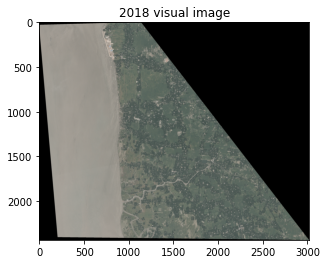

In [313]:
plt.figure(0)
plt.imshow(visual_image)
plt.title("2018 visual image")

Notice how we have a strip of coastline on the right of the image, and water on the left. Let's see what our NDWI distribution looks like.

Text(0.5, 1.0, '2018 NDWI Values')

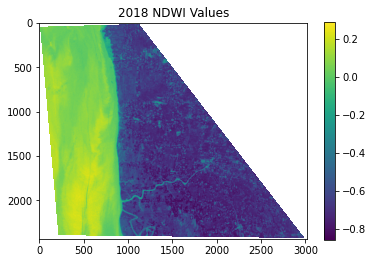

In [314]:
plt.figure(0)
plt.imshow(ndwi)
plt.colorbar()
plt.title("2018 NDWI Values")

Now let's take a look at the masks we created. Our find_water_and_land function gives us two arrays - both with 0s and 1s, indicating where we can find water v.s. land. Let's take a moment to visualize our land mask. Note: NANs represent regions of the maps that have been clipped.

In [315]:
land_mask

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.]])

Text(0.5, 1.0, '2018 land mask')

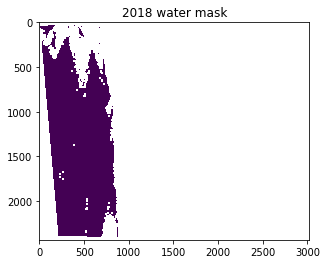

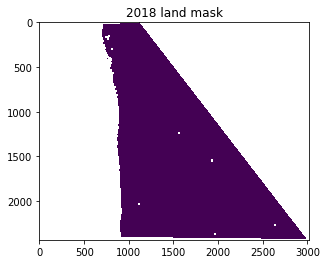

In [290]:
plt.figure(0)
plt.imshow(water_mask)
plt.title("2018 water mask")

plt.figure(1)
plt.imshow(land_mask)
plt.title("2018 land mask")

Notice how we see holes in the water and land masks? In the water mask, it is likely due to the fact that we are imaging esecially murky water with either excessive vegetation growth, or perhaps these pixels are associated with sandbars off of the coast! For the land mask, we are likely picking up small bodies of water inland.

For our coastline analysis, it would be most helpful for us to have clean distinctions between what is "mostly land" to what is "mostly water". We can do this by applying filters to clean-up our pixel classficiation. 

## Apply Filters
We can apply [morophological filters](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html)
to filter out the unwanted pixels in the water and land masks.
We use a closing filter will close small clusters of pixels (e.g., holes) inside parts of a mask.
Following, we use an opening filter will remove any small clusters of pixels outside a mask.

In [291]:
def filter_mask(closing_kernel_size, opening_kernel_size, mask):
    """
    Given a mask, apply morphological filters (closing followed by opening) 
    to filter out unwanted pixels.

    Parameters:
    -----------
    # The size of the closing and opening kernels in pixels
       closing_kernel_size : Int
                             Size of the closing kernel in pixels
       opening_kernel_size : Int
                             Size of the opening kernel in pixels

        mask : Array[int]
               A binary mask
    
    Returns:
    --------
        mask_closed_opened : Array[int]
               A morphologically filtered binary mask
    """

    # Apply closing filter (remove empty pixels within mask)
    closing_kernel_element = (closing_kernel_size, closing_kernel_size)
    closing_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,
                                               closing_kernel_element)
    mask_closed = cv2.morphologyEx(np.nan_to_num(mask), cv2.MORPH_CLOSE,
                                   closing_kernel)

    # Apply opening filter (removing filled pixels outside of mask)
    opening_kernel_element = (opening_kernel_size, opening_kernel_size)
    opening_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,
                                               opening_kernel_element)
    mask_closed_opened = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN,
                                          opening_kernel)

    # Ensure the clipped areas remain clipped
    mask_closed_opened[mask_closed_opened == 0] = np.nan

    return mask_closed_opened

Let's see this how this works in practice:

In [292]:
# Filter the water mask
closing_kernel_size = 29
opening_kernel_size = 13
water_mask_filtered = filter_mask(closing_kernel_size, opening_kernel_size,
                                  water_mask)

# Filter the land mask
closing_kernel_size = 3
opening_kernel_size = 101
land_mask_filtered = filter_mask(closing_kernel_size, opening_kernel_size,
                                 land_mask)

Text(0.5, 1.0, '2018 filtered land mask')

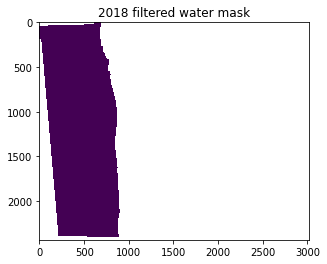

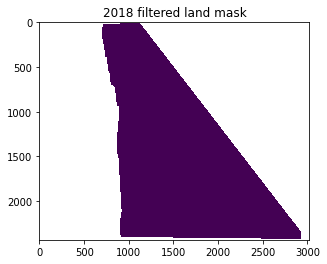

In [293]:
plt.figure(0)
plt.imshow(water_mask_filtered)
plt.title("2018 filtered water mask")

plt.figure(1)
plt.imshow(land_mask_filtered)
plt.title("2018 filtered land mask")

Viola! Now we have clear distinctions between land and water without any pesky pixels to distract us!

Now, we can implement this entire process we just walked through, to each of the images over the time series, from 2017 to 2022.

In [294]:
NUM_YEARS = 2022 - 2017
all_land_masks = []

for n in range(NUM_YEARS + 1):
    # Extract green, red, and NIR data from 4-Band imagery
    band_green, band_nir = extract_spectral_bands(analytic_filenames[n])
    # Extract visual images
    visual_image = compose_scene(visual_filenames[n])
    # Compute NDWI
    ndwi = measure_ndwi(band_green, band_nir)
    # Mask regions with water
    water_mask, land_mask = find_water_and_land(ndwi)
    # Filter masks to fill out space
    water_mask_filtered = filter_mask(29, 13, water_mask)
    land_mask_filtered = filter_mask(3, 101, land_mask)
    # Add land mask to a list for further analysis
    all_land_masks.append(land_mask_filtered)

## Analyze Results 

Now that we have our NDWI thresholds and land/water masks calculated over all of our data, we can start interpreting the year-over-year changes.

Let's first look at landmass loss by calculating the physical area of land lost over time.

### Landmass Loss

In [295]:
land_difference = np.nan_to_num(all_land_masks[0]) - np.nan_to_num(
    all_land_masks[-1])

# resolution in m
resolution = 3.7
# area per pixel in m^2
area_per_pixel = resolution**2

time = np.array(range(len(all_land_masks)))
landmass_loss = np.nansum(all_land_masks[0]) - list(
    map(np.nansum, all_land_masks))
landmass_loss_velocity = np.diff(landmass_loss) / np.diff(time)
landmass_loss_acceleration = np.diff(landmass_loss_velocity) / np.diff(
    time[1:])

In [296]:
print("Total landmass lost: " +
      str(np.nansum(land_difference) * area_per_pixel) +
      " m^2 over the past " + str(NUM_YEARS) + " years")

Total landmass lost: 11067132.9 m^2 over the past 5 years


Let's visualize the total landmass lost over our time series.

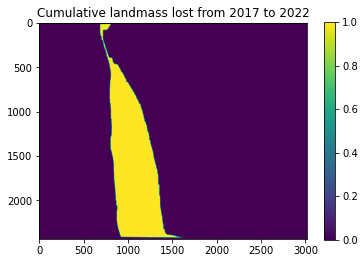

In [297]:
# Total Landmass Lost
plt.figure(4)
plt.imshow(land_difference)
plt.colorbar()
plt.title("Cumulative landmass lost from 2017 to 2022")
plt.show()

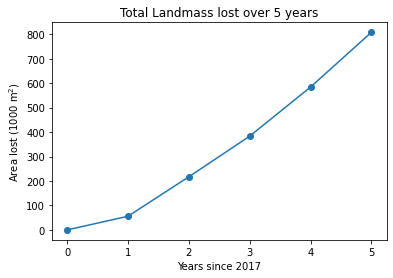

In [298]:
# Cumulative Landmass Lost
plt.figure(5)
plt.plot(time, landmass_loss * 1e-3, 'o-')
plt.title("Total Landmass lost over 5 years")
plt.xlabel("Years since 2017")
plt.ylabel(r"Area lost (1000 m$^2$)")
plt.show()

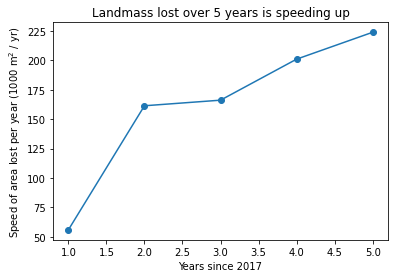

In [299]:
# Velocity of Landmass Lost
plt.figure(6)
plt.plot(time[1:], landmass_loss_velocity * 1e-3, 'o-')
plt.title("Landmass lost over 5 years is speeding up")
plt.xlabel("Years since 2017")
plt.ylabel(r"Speed of area lost per year (1000 m$^2$ / yr)")
plt.show()

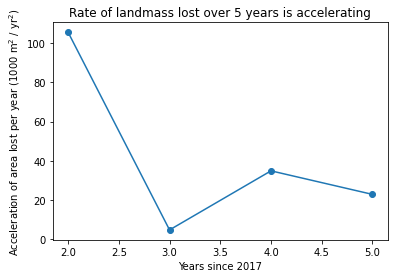

In [300]:
# We see that our landmass loss over the past 5 years is accelerating
plt.figure(7)
plt.plot(time[2:], landmass_loss_acceleration * 1e-3, 'o-')
plt.title("Rate of landmass lost over 5 years is accelerating")
plt.xlabel("Years since 2017")
plt.ylabel(r"Acceleration of area lost per year (1000 m$^2$ / yr$^2$)")
plt.show()

### Land Recession

We can also measure coastline erosion through land recession, or how much the coastline has receded in land. One way to look at the amount of receded land is through edge detection. We can use a computer viion algorithm called Canny Edge Detection to detect the edge of the landmass at the beginning and end of our time series. Then, we can compare those values to get a different perspective on how much coastline has been lost.

You can learn more about edge detection method we are using here: https://learnopencv.com/edge-detection-using-opencv/

In [301]:
# Detect the edges of the cumulative land loss map
edges_all = cv2.Canny(image=np.uint8(land_difference),
                      threshold1=0,
                      threshold2=1)

# Bin up all edge pixels, vertically
_, xpos = np.where(edges_all > 0)
NUM_BINS = 12
N, x = np.histogram(xpos, bins=NUM_BINS)
bin_width = x[1] - x[0]

# Find the peaks of the histogram -> these are the coastline edges
coastlines = x[find_peaks(N)[0]]
coastline_2017 = coastlines[0]
coastline_2022 = coastlines[1]

The below plot shows the relative x-axis edge values for our coastline in 2017 and in 2022, for comparison. The histogram overlayed on top shows where the edge of the coastline is most likely to be.

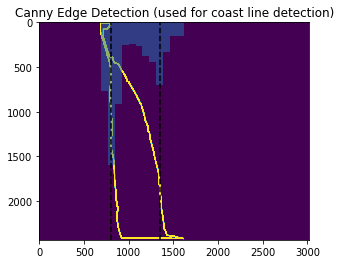

In [302]:
plt.figure(8)
plt.imshow(edges_all, vmin=0, vmax=1)
plt.hist(xpos, bins=NUM_BINS, alpha=0.5)
plt.axvline(x=coastline_2017+bin_width/2, color='k', ls='--')
plt.axvline(x=coastline_2022+bin_width/2, color='k', ls='--')
plt.title("Canny Edge Detection (used for coast line detection)")
plt.show()

In [303]:
recession = (coastline_2022 - coastline_2017) * resolution

print(f"Land has receded {recession} meters in {NUM_YEARS} years")
print(
    f"Land has receded {recession / NUM_YEARS} meters/yr over the past {NUM_YEARS} years"
)

Land has receded 2005.0916666666674 meters in 5 years
Land has receded 401.0183333333335 meters/yr over the past 5 years


## Congratulations!!

You've made it to the end of this tutorial! 

We hope you now have a better understanding of how to use geospatial/raster image processing and computer vision tools to analyze coastal erosion.

If you have any additional questions, please don't hesitate to reach out to us using the email addresses below.

Kevin Lacaille: kevin.lacaille@planet.com

Mansi Shah: mansi@planet.com

Develepr Relations @ Planet: developers@planet.com